In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import lon180cesm, lon180, salmask, latweights, makedz

In [2]:
datafolder = ''

In [3]:
experiment = 'E280' 
model = 'NorESM1-F'
folder = datafolder+'/Raw_data/'+model+'/'

In [4]:
if experiment == 'Eoi400':
    dsV = xr.open_dataset(folder+experiment+'/PlioMIP2_03.micom.hy.2400-2499mean.vvellvl.nc')
    dsS = xr.open_dataset(folder+experiment+'/PlioMIP2_03.micom.hy.2400-2499mean.salnlvl.nc')
    dsr = xr.open_dataset(folder+experiment+'/grid.nc')
else:
    dsV = xr.open_dataset(folder+experiment+'/NBF1850OC_f19_tn11_02.micom.hy.1900-1999mean.vvellvl.nc')
    dsS = xr.open_dataset(folder+experiment+'/NBF1850OC_f19_tn11_02.micom.hy.1900-1999mean.salnlvl.nc')
    dsr = xr.open_dataset(folder+experiment+'/grid.nc')
    
dsV['lat']=dsr.vlat
dsV['lon']=dsr.vlon

dsS['lat']=dsr.plat
dsS['lon']=dsr.plon

In [5]:
#Convert region file to NetCDF
f = open(folder+experiment+'/mask.dat', 'r')
i=0
mask = np.zeros([360,385])
for line in f:
    line = line.split()
    if i>=1:
        mask[i-1,:] = [int(a) for a in str(line[0])]
    i = i+1
mask = np.transpose(mask)

da = xr.DataArray(data=mask, dims=["y", "x"], attrs=dict(description="Region mask"))
dsr['region']=da

## Separating overturning and gyre FW Atlantic

In [6]:
salt = dsS.salnlvl[0]
region=dsr.region

regridder = xe.Regridder(dsV, dsS, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.vvellvl[0].fillna(0)*100 #velocity in cm/s
vvel = regridder(vo)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [8]:
#1-D array with spacing of depth grid
ds = dsS.copy(deep=True)

dz = np.zeros(len(ds.depth))
dz[0] = ds.depth[1]-ds.depth[0]
for i in range(1,len(ds.depth)):
    dz[i] = (ds.depth[i]-ds.depth[i-1])
dz = dz*100 #Depth spacing. Units: cm
dsS['dz'] = xr.DataArray(data=dz, dims=("depth"))
dz = dsS.dz

#Horizontal grid spacing
DXT = dsr.pdx*100 #[cm]

In [9]:
#Define reference salinity S0 as average Atlantic salinity
folder2 = datafolder+'Processed/'
dssal = xr.open_dataset(folder2+model+'/'+experiment+'/so_1x1_100yr.nc')
dssal = lon180(dssal)

S0 = dssal.so.where(salmask()>-1).weighted(dz).mean(dim='z').weighted(latweights()).mean()

In [10]:
SALT = salt.where(region==2)  #  [g/kg]

VVEL = vvel.where(region==2)
VVEL = VVEL*SALT/SALT #cm/s

In [11]:
def zonal_means(x, dx):
    xint = (x*dx).sum('x')  # [x-unit * cm]
    zm = xint/dx.sum('x')   # [x-unit]
    return zm

VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) []
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]

Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['x','depth']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['x','depth']))/1e12

Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['x','depth']))/1e12

In [13]:
# auxiliary latitudes 
lats = dsS.lat.where(region==2).mean('x')

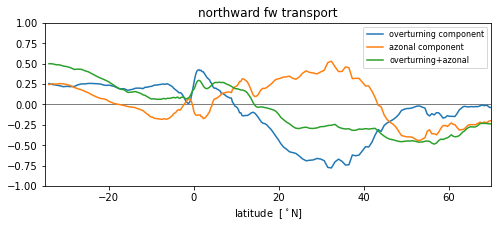

In [14]:
plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Fov, label='overturning component')

plt.plot(lats, Faz, label='azonal component')
plt.plot(lats, Ftotal, label='overturning+azonal')
plt.title('northward fw transport')
plt.xlim([-35,70])
plt.ylim([-1,1])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [15]:
if experiment == 'E280':
    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[104:-50]), Faz=(["lat"], Faz[104:-50]), Ftot=(["lat"], Ftotal[104:-50])), coords = dict(lat = lats[104:-50].values))
elif experiment == 'Eoi400':
    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[104:-50]), Faz=(["lat"], Faz[104:-50]), Ftot=(["lat"], Ftotal[104:-50])), coords = dict(lat = lats[104:-50].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_100yr.nc')

## FW Labrador

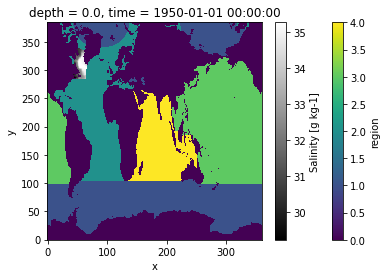

In [16]:
#check region
region.plot()
dsS.salnlvl[0,0].where(region==2).where(dsS.lon<-45).where(dsS.lon>-68).where(dsS.lat>=45).where(dsS.lat<70).plot(cmap='gray') #Labrador Sea

In [17]:
SALT = salt.where(region==2).where(dsS.lon<-45).where(dsS.lon>-68).where(dsS.lat>=45).where(dsS.lat<70)  
VVEL = vvel.where(region==2).where(dsS.lon<-45).where(dsS.lon>-68).where(dsS.lat>=45).where(dsS.lat<70)
    
VVEL = VVEL*SALT/SALT #cm/s

VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) []
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]
    
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['x','depth']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['x','depth']))/1e12

Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['x','depth']))/1e12

# auxiliary latitudes
lats = dsS.lat.where(region==2).where(dsS.lon<-45).where(dsS.lon>-68).where(dsS.lat>=45).where(dsS.lat<70).mean('x')

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[290:340]), Faz=(["lat"], Faz[290:340]), Ftot=(["lat"], Ftotal[290:340])), coords = dict(lat = lats[290:340].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Lab_100yr.nc')

## FW Fram Strait

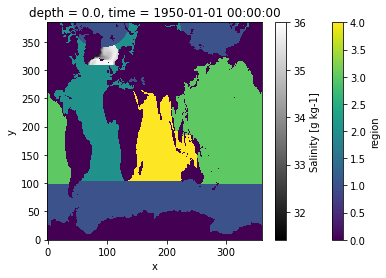

In [18]:
#check region
region.plot()
dsS.salnlvl[0,0].where(region==2).where(dsS.lon>=-45).where(dsS.lat>=60).where(dsS.lon<=15).plot(cmap='gray') #Labrador Sea

In [20]:
SALT = salt.where(region==2).where(dsS.lon>=-45).where(dsS.lat>=60).where(dsS.lon<=15) 
VVEL = vvel.where(region==2).where(dsS.lon>=-45).where(dsS.lat>=60).where(dsS.lon<=15)
    
VVEL = VVEL*SALT/SALT #cm/s

VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) []
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]
    
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['x','depth']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['x','depth']))/1e12

Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['x','depth']))/1e12

# auxiliary latitudes 
lats = dsS.lat.where(region==2).where(dsS.lon>=-45).where(dsS.lat>=60).where(dsS.lon<=15).mean('x')

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[-76:-45]), Faz=(["lat"], Faz[-76:-45]), Ftot=(["lat"], Ftotal[-76:-45])), coords = dict(lat = lats[-76:-45].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Fram_100yr.nc')

## FW transport Bering Strait

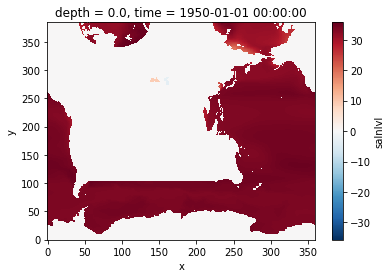

In [22]:
#check region
a = dsS.salnlvl[0,0].where(region==1).fillna(0)+dsS.salnlvl[0,0].where(region==3).fillna(0)
a.plot()

In [23]:
if experiment =='E280':
    SALT = salt.where(region==1).where(dsS.x>200).where(dsS.y>300).where(dsS.y<350)
    VVEL = vvel.where(region==1).where(dsS.x>200).where(dsS.y>300).where(dsS.y<350)

    VVEL = VVEL*SALT/SALT #cm/s

    VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
    SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

    SALT_zm_3D = SALT/SALT
    SALT_zm_3D = SALT_zm_3D*SALT_zm

    VVEL_zm_3D = VVEL/VVEL
    VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

    # azonal components
    SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) []
    VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]

    Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['x','depth']))/1e12 # 1 Sv = 1e12 cm^3/s
    Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['x','depth']))/1e12
    Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['x','depth']))/1e12

    # auxiliary latitudes
    lats = dsS.lat.where(region==1).where(dsS.x>200).where(dsS.y>300).where(dsS.y<350).mean('x')

    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[-60:-40]), Faz=(["lat"], Faz[-60:-40]), Ftot=(["lat"], Ftotal[-60:-40])), coords = dict(lat = lats[-60:-40].values))
    xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_BS_100yr.nc')